Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available Classes: ['ice_cream', 'edamame', 'ramen', 'sushi', 'falafel', 'tiramisu', 'cannoli', 'french_toast', 'bibimbap', 'apple_pie']
Data split completed.
Found 1050 images belonging to 10 classes.
Found 640 images belonging to 10 classes.
Found 310 images belonging to 10 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 126, 126, 32)      0         
                                   

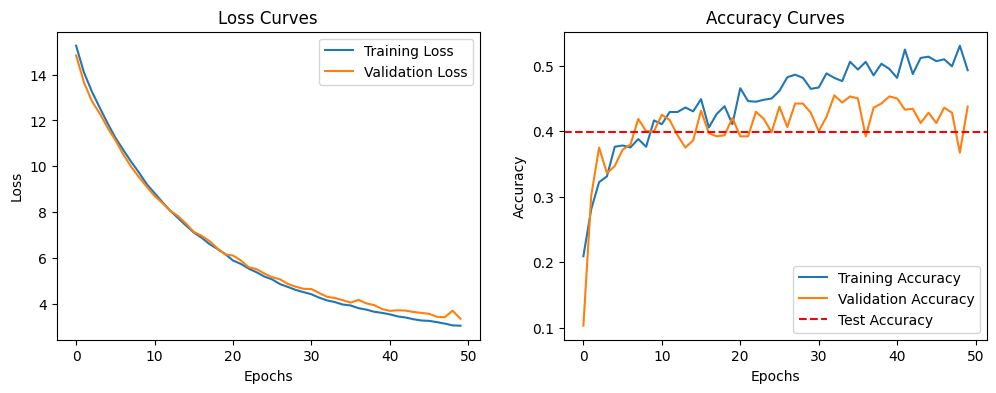

In [2]:
import os
import shutil
import random
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
BASE_DIR = '/content/drive/MyDrive/food_files/data/food-101-tiny'
ORIGINAL_TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')
NEW_TRAIN_DIR = os.path.join(BASE_DIR, 'new_train')

# Create new directories if they don't exist
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
if not os.path.exists(NEW_TRAIN_DIR):
    os.makedirs(NEW_TRAIN_DIR)

# Get available classes
available_classes = os.listdir(ORIGINAL_TRAIN_DIR)
print("Available Classes:", available_classes)

# Create class subdirectories in the new train, validation, and test directories
for class_name in available_classes:
    os.makedirs(os.path.join(NEW_TRAIN_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(VALID_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

# Split function
def split_data(SOURCE_DIR, TRAIN_DIR, VALID_DIR, TEST_DIR, split_ratios=(0.7, 0.2, 0.1)):
    for class_name in available_classes:
        class_dir = os.path.join(SOURCE_DIR, class_name)
        images = os.listdir(class_dir)
        images = [os.path.join(class_dir, img) for img in images]

        # Shuffle the images
        random.shuffle(images)

        # Calculate split indices
        train_split_idx = int(len(images) * split_ratios[0])
        valid_split_idx = int(len(images) * (split_ratios[0] + split_ratios[1]))

        train_images = images[:train_split_idx]
        valid_images = images[train_split_idx:valid_split_idx]
        test_images = images[valid_split_idx:]

        # Move the images
        for img in train_images:
            shutil.move(img, os.path.join(TRAIN_DIR, class_name, os.path.basename(img)))

        for img in valid_images:
            shutil.move(img, os.path.join(VALID_DIR, class_name, os.path.basename(img)))

        for img in test_images:
            shutil.move(img, os.path.join(TEST_DIR, class_name, os.path.basename(img)))

# Run the split
split_data(ORIGINAL_TRAIN_DIR, NEW_TRAIN_DIR, VALID_DIR, TEST_DIR)

print("Data split completed.")

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
CLASSES = available_classes  # Use available_classes

# Data generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    NEW_TRAIN_DIR,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=BATCH_SIZE
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=BATCH_SIZE
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Create CNN model with L2 regularization and Batch Normalization
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation=None, input_shape=(128, 128, 3), kernel_regularizer=l2(0.1)))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, scale=True, center=True))
model.add(tf.keras.layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation=None, kernel_regularizer=l2(0.1)))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, scale=True, center=True))
model.add(tf.keras.layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Third Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu', kernel_regularizer=l2(0.1)))



# Flatten Layer
model.add(Flatten())

# Output Layer
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.1)))

model.summary()

# Compile and train the model function
def compile_and_train_model(model, optimizer, learning_rate, epochs, batch_size):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return history

# Plotting function with test accuracy
def plot_history_with_test(history, test_accuracy):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')

    plt.show()

# Train the model
history = compile_and_train_model(model, optimizer='adam', learning_rate=0.0001, epochs=50, batch_size=BATCH_SIZE)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history with test accuracy
plot_history_with_test(history, test_accuracy)


10/10 [==============================] - 2s 173ms/step


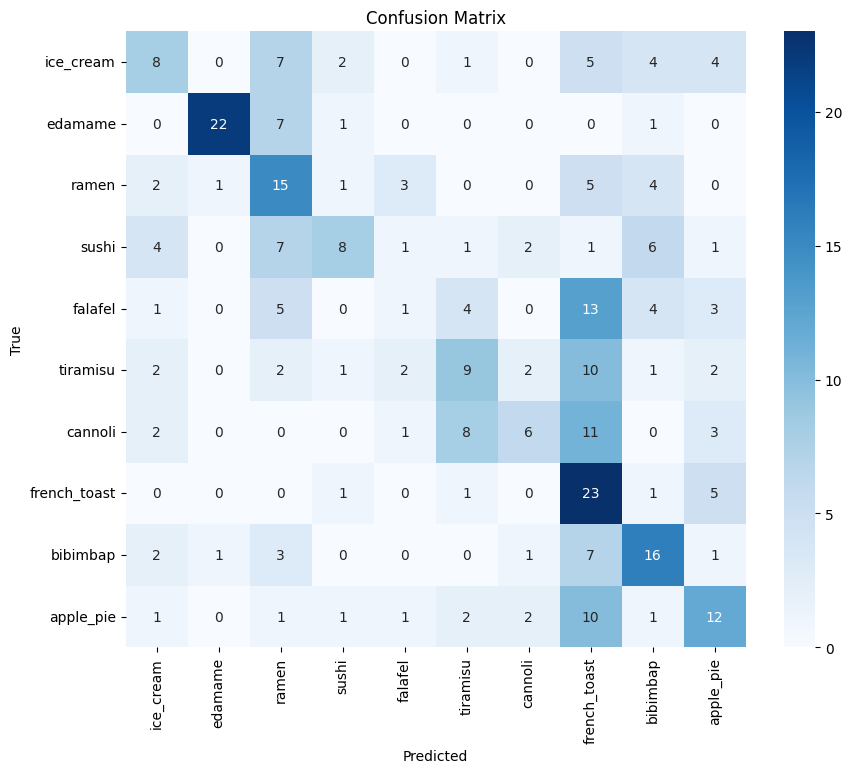

Cohen's Kappa: 0.31899641577060955


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
# Predict on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa}")